
# The protocol header
```
#pragma once
#include <stdint.h>
#define MAGIC 0x47494A53484F4D4F
struct output_hdr_t
{
  uint64_t magic;               # unsigned long long
  uint32_t fits_header_size;    # unsigned long
  uint32_t array_size;          # unsigned long
  uint8_t pad[512-16];
};
```

In [1]:
import socket
import StringIO
import struct

import astropy.io.fits.header
import astropy.io.fits

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
HOSTNAME = 'localhost'
PORT = 6000

In [3]:
checksum = 0x47494A53484F4D4F

In [4]:
def getbytes(socket_, bytes_):
    """Read an amount of bytes from the socket"""
    result = StringIO.StringIO()
    count = bytes_
    while count > 0:
        recv = socket_.recv(count)
        if len(recv) == 0:
            raise Exception("Server closed connection")
        count -= len(recv)
        result.write(recv)
    return result.getvalue()

In [5]:
def read_window(socket_):
    """
    read raw aarfaac protocol window
    
    returns: fits_bytes, image_bytes
    """
    header_bytes = getbytes(socket_, 512)
    magic = struct.unpack('Q', header_bytes[:8])[0]
    fits_length = struct.unpack('=L', header_bytes[8:12])[0]
    array_length = struct.unpack('=L', header_bytes[12:16])[0]
    assert magic == checksum, str(magic) + '!=' + str(checksum)
    fits_bytes = getbytes(socket_, fits_length)
    image_bytes = getbytes(socket_, array_length)
    return fits_bytes, image_bytes


In [6]:
def reconstruct_fits(fits_bytes, image_bytes):
    hdu_header = astropy.io.fits.header.Header.fromstring(fits_bytes)   
    width = hdu_header["NAXIS1"]
    length = hdu_header["NAXIS2"]
    image_array = struct.unpack(str(len(image_bytes)/4) + 'f', image_bytes)
    image_matrix = np.reshape(image_array, (width, length))
    hdu = astropy.io.fits.PrimaryHDU(image_matrix)
    hdu.header = hdu_header
    hdulist = astropy.io.fits.HDUList([hdu])
    return hdulist

0
1
2
3
4


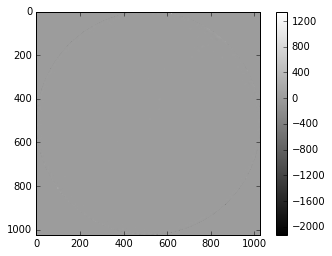

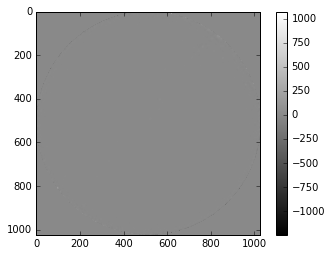

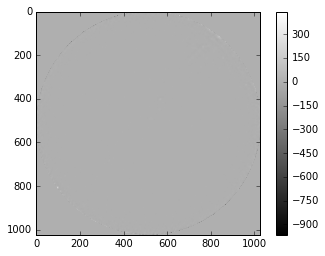

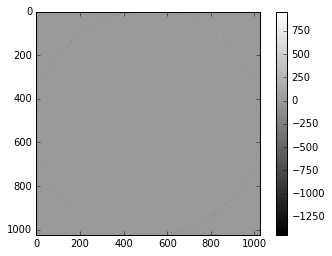

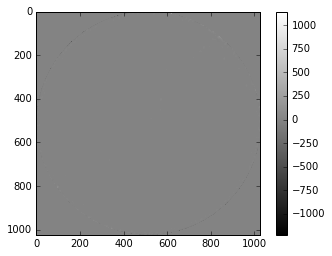

In [7]:
socket_ = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
socket_.connect((HOSTNAME, PORT))

for i in range(5):
    print i 
    fits_bytes, image_bytes = read_window(socket_)
    fits = reconstruct_fits(fits_bytes, image_bytes)
    plt.figure(i)
    plt.imshow(fits[0].data, cmap='gray')
    plt.colorbar()
